# Event-study

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import wrds
import re
import matplotlib.pyplot as plt
import numpy as np
import re
from cleanco import basename
from tqdm.notebook import tqdm
import dask
dask.config.set(scheduler="processes")
from tqdm.dask import TqdmCallback
from linearmodels.system import SUR
import seaborn as sns
import plotly.graph_objects as go
from collections import OrderedDict
import scipy.stats as stats
import statsmodels.api as sm

In [3]:
#import functions from functions.py
from function_definitions import *

## PRC data

In [474]:
#read in the data from PRC
prc_data = pd.read_csv('../data/PRC/PRC-DatabreachChronology-v1-03.02.2023.csv')

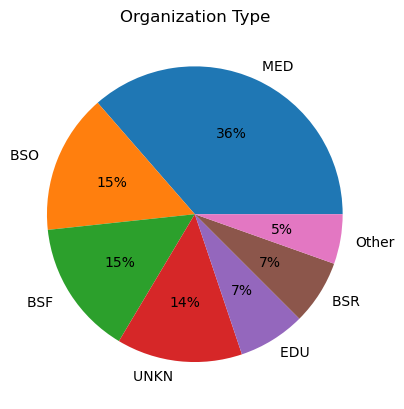

Other category regroups the following:


GOV                                                                               4.032538
NGO                                                                               1.304499
\n\nMED                                                                           0.014880
\n\nBSO                                                                           0.009920
\n\nBSR                                                                           0.009920
\n\nUNKN                                                                          0.009920
Based on the information provided, the organization should be labeled as BSF      0.004960
\nMED                                                                             0.004960
This organization is likely EDU (Educational Institutions)                        0.004960
BSo                                                                               0.004960
Based on the information provided, this organization should be labeled as BSF     0.004960

In [475]:
# Compute the value counts of organization types
value_counts = prc_data['Organization Type'].value_counts()

# Calculate the percentage for each organization type
percentage = (value_counts / len(prc_data)) * 100

# Threshold for grouping into "Other" category (5%)
threshold = 5

# Create a mask for organization types with percentage less than the threshold
mask = percentage < threshold

# Group organization types with less than threshold into "Other" category
other_count = value_counts[mask].sum()
value_counts = value_counts[~mask]
value_counts['Other'] = other_count

value_counts.plot.pie(autopct="%.0f%%", ylabel = '', title = 'Organization Type')
plt.show()

print('Other category regroups the following:')
percentage[mask]

In [476]:
#fix the organisation types
prc_data['Organization Type'] = prc_data['Organization Type'].str.replace('\n','').str.upper().str.strip()
#prc_data['Organization Type'].value_counts()

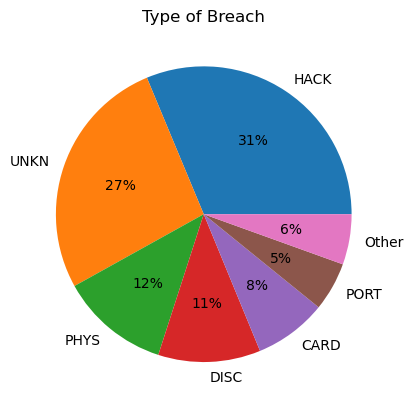

In [477]:
#fix the breach types
prc_data['Type of Breach'] = prc_data['Type of Breach'].str.replace('\n','').str.upper().str.strip()

# Compute the value counts of organization types
value_counts = prc_data['Type of Breach'].value_counts()

# Calculate the percentage for each organization type
percentage = (value_counts / len(prc_data)) * 100

# Threshold for grouping into "Other" category (10%)
threshold = 5

# Create a mask for organization types with percentage less than the threshold
mask = percentage < threshold

# Group organization types with less than threshold into "Other" category
other_count = value_counts[mask].sum()
value_counts = value_counts[~mask]
value_counts['Other'] = other_count

value_counts.plot.pie(autopct="%.0f%%", ylabel = '', title = 'Type of Breach')
plt.show()

In [478]:
#contingency table
prc_data = prc_data[prc_data['Organization Type'].str.len()<5]
prc_data = prc_data[prc_data['Type of Breach'].isin(['HACK','UNKN','STAT','PORT','CARD'])]
contingency_table = pd.crosstab(prc_data['Type of Breach'], prc_data['Organization Type'])
contingency_table = contingency_table.loc[:, contingency_table.sum().sort_values(ascending=False).index]
contingency_table = contingency_table.loc[contingency_table.sum(axis=1).sort_values(ascending=False).index]
contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum()
contingency_table

Organization Type,MED,UNKN,BSO,BSF,BSR,EDU,GOV,NGO,BSH,Total
Type of Breach,,,,,,,,,,
HACK,1688,638,1702,785,671,574,164,84,0,6306
UNKN,2136,1695,337,557,92,287,173,124,0,5401
CARD,26,52,256,678,541,29,13,4,1,1600
PORT,584,73,123,103,15,88,79,10,0,1075
STAT,180,8,8,7,3,11,6,0,0,223
Total,4614,2466,2426,2130,1322,989,435,222,1,14605


In [494]:
prc_data[~prc_data['Date of Breach'].str.contains('/').replace(np.nan,False)]['Date of Breach']

131       NOT PROVIDED
132       NOT PROVIDED
133       NOT PROVIDED
135       NOT PROVIDED
139      NOT PROVIDED 
             ...      
20150              NaN
20152              NaN
20153              NaN
20154              NaN
20160              NaN
Name: Date of Breach, Length: 4375, dtype: object

In [488]:
prc_data['Reported Date'].str.contains('/')

0         True
5         True
6         True
7         True
10        True
         ...  
20154    False
20157    False
20158    False
20159    False
20160    False
Name: Reported Date, Length: 14605, dtype: bool

In [398]:
def categorize_report_date(date_str):
    date_str = str(date_str)
    if pd.to_datetime(date_str, errors='coerce') is not pd.NaT:
        return 'Yes'
    elif re.search(r'\d{1,2}/\d{1,2}/\d{1,2}', date_str):
        return 'Maybe'
    else:
        return 'No'
    
prc_data['Report Date Available'] = prc_data['Reported Date'].apply(categorize_report_date)
contingency_table = pd.crosstab(prc_data['Report Date Available'], prc_data['Organization Type'])
contingency_table = contingency_table.loc[:, contingency_table.sum().sort_values(ascending=False).index]
contingency_table = contingency_table.loc[contingency_table.sum(axis=1).sort_values(ascending=False).index]
contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum()
contingency_table

Organization Type,MED,UNKN,BSO,BSF,BSR,EDU,GOV,NGO,BSH,Total
Report Date Available,,,,,,,,,,
Yes,4439,2362,2222,2022,1181,936,426,218,1,13807
Maybe,136,63,176,95,133,46,3,3,0,655
No,39,41,28,13,8,7,6,1,0,143
Total,4614,2466,2426,2130,1322,989,435,222,1,14605


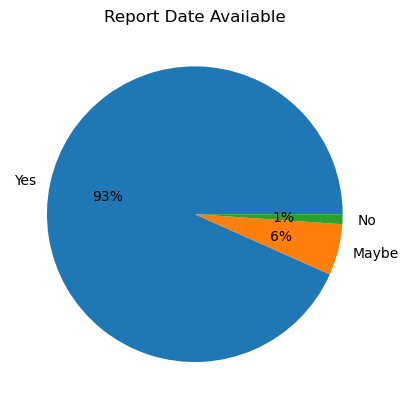

In [399]:
prc_data[prc_data['Organization Type'].isin(['BSO','BSF','BSR','UNKN'])]['Report Date Available'].value_counts().plot.pie(autopct="%.0f%%", title = 'Report Date Available', ylabel = '')
plt.show()

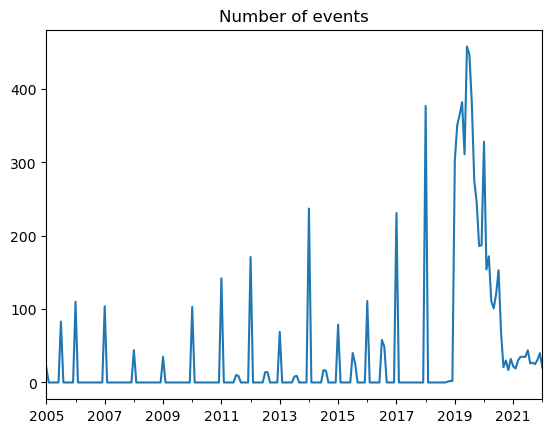

In [460]:
temp = pd.to_datetime(prc_data[prc_data['Report Date Available'] == 'Yes']['Reported Date']).dt.to_period('M')
temp = temp.value_counts()
complete_months = pd.date_range(start=temp.index.to_timestamp().min(), end=temp.index.to_timestamp().max(), freq='M')
temp = temp.reindex(complete_months.strftime('%m/%Y'), fill_value=0)
temp = temp.sort_index(key=lambda x: pd.to_datetime(x, format='%m/%Y'))
temp.index = pd.to_datetime(temp.index)
temp.plot()
plt.title('Number of events')
plt.show()

In [401]:
#prc_data[(prc_data['Type of Breach'] == 'HACK') & (prc_data['Report Date Available'] == 'Yes') &
#         (prc_data['Organization Type'].isin(['BSR','BSF','BSO'])) & (prc_data['Source'] != 'Dataloss DB')]

In [402]:
#prc_data[(prc_data['Type of Breach'] == 'HACK') & (prc_data['Report Date Available'] == 'Yes') &
#         (prc_data['Organization Type'].isin(['BSR','BSF','BSO']))]['Reported Date'].value_counts().iloc[:20]

In [403]:
#limit prc data to businesses with known breach report dates
prc_data = prc_data[(prc_data['Organization Type'].isin(['BSR','BSF','BSO','UNKN'])) &
                    (prc_data['Report Date Available'] != 'No')]

In [404]:
#fix lines that are ambiguous
prc_data['Name of Entity'] = prc_data['Name of Entity'].apply(lambda x: re.sub(r'(,|) doing business as',',',x))
prc_data['Name of Entity'] = prc_data['Name of Entity'].apply(lambda x: re.sub(r'& possibly',',',x))
#split the Names of entities on the same event into separate columns
temp = prc_data['Name of Entity'].str.split(',', n = -1, expand = True)
NoE_columns = [f"NoE{i}" for i in range(1, temp.shape[1] + 1)]
prc_data[NoE_columns] = temp
print('Number of non-null elements in each column:')
(~prc_data[NoE_columns].isnull()).sum(0)

Number of non-null elements in each column:


NoE1    8254
NoE2     389
NoE3      74
NoE4      18
NoE5       4
NoE6       2
NoE7       1
dtype: int64

## match company names on the PRC data with cusips

In [405]:
def try_sub_chars(x, not_alphabet):
    try:
        return not_alphabet.sub('',x)
    except:
        return x

def try_basename(x,basename):
    try:
        return basename(x)
    except:
        return x
        
#lowercase
for col in NoE_columns:
    prc_data[col] = prc_data[col].str.lower()
stocknames.comnam = stocknames.comnam.str.lower()
#remove non letters or numbers
not_alphabet = re.compile('[^a-z\s0-9]')
for col in NoE_columns:
    prc_data[col] = prc_data[col].apply(lambda x: try_sub_chars(x, not_alphabet))
stocknames.comnam = stocknames.comnam.apply(lambda x: not_alphabet.sub('',x))
#strip away terms indicating organization type
for col in NoE_columns:
    prc_data[col] = prc_data[col].apply(lambda x: try_basename(x, basename))
stocknames.comnam = stocknames.comnam.apply(lambda x: basename(x))
#get rid of duplicate company name stocks
stocknames = stocknames[stocknames.comnam.notnull()]
stocknames.sort_values('end_date', ascending = False, inplace = True)
to_drop = []
#keep the observation that has the most recent observation
#if there are several, keep one one with the oldest observation
duplicated_comnams = stocknames[stocknames.duplicated(subset = 'comnam')].comnam.unique()
for comnam in duplicated_comnams:
    sn = stocknames[stocknames.comnam == comnam]
    sn = sn[sn.end_date == sn.end_date.max()]
    #if several have recent observations keep the one with the furthest start date
    if len(sn) > 1:
        sn = sn[sn.st_date == sn.st_date.min()]
    to_keep = sn.index.values[0]
    indexes = stocknames[stocknames.comnam == comnam].index.values
    to_drop.append(indexes[~np.isin(indexes, to_keep)])
to_drop = np.concatenate(to_drop).ravel()
stocknames = stocknames.drop(labels = to_drop)
stocknames.reset_index(inplace = True, drop = True)
stocknames = stocknames[stocknames.comnam != '']

In [295]:
def find_comnames(text, names):
    #find company names contained in text
    found_names = []
    for name in names:
        if re.search('(\s|^)'+name+'($|\s)',text) or re.search('(\s|^)'+text+'($|\s)',name):
            found_names.append(name)
    
    #compute the percentage of common words
    percentage_common_wrds = []
    for name in found_names:
        words_text = set(text.split())
        words_comnam = set(name.split())
        common_words = words_text.intersection(words_comnam)
        percentage_common_wrds.append(len(common_words)/(len(words_text)+len(words_comnam)))
        
    return found_names, percentage_common_wrds

In [296]:
@dask.delayed()
def find_tickers(entity_name, stocknames):
    temp_wrds = stocknames.copy()
    temp_wrds.comnam = stocknames.comnam.apply(lambda x: re.sub('\s','',x))
    entity_name_ = re.sub('\s','',entity_name)
    try:
        ticker = stocknames[temp_wrds.comnam == entity_name_]['ticker'].values[0]
        cusip = stocknames[temp_wrds.comnam == entity_name_]['cusip'].values[0]
        probability = 'HIGH'
        
    except:
        try:
            comnams, pct_common_words = find_comnames(entity_name,stocknames.comnam)
            most_sim = comnams[np.argmax(pct_common_words)]
            ticker = stocknames[stocknames.comnam == most_sim]['ticker'].values[0]
            cusip = stocknames[stocknames.comnam == most_sim]['cusip'].values[0]
            if max(pct_common_words) >= 1/3:
                probability = 'MID'
            else:
                probability = 'LOW'
        except:
            ticker = None
            cusip = None
            probability = None
            
    return ticker, cusip, probability

In [299]:
temp_wrds = stocknames.copy()
temp_wrds.comnam = stocknames.comnam.apply(lambda x: re.sub('\s','',x))
allpromises = []
prc_names = []
NoEs = np.concatenate(prc_data.filter(like = 'NoE').values)
NoEs = np.unique([item for item in NoEs if item is not None and item != ''])
for i in NoEs:
    allpromises.append(find_tickers(i,stocknames))
    prc_names.append(i)
with TqdmCallback(desc = 'Matching companies'):
    tickers = dask.compute(allpromises)[0]
        
tickers = pd.DataFrame(tickers)
tickers.columns = ['ticker','cusip','probability']
tickers['PRC_NoE'] = prc_names

Matching companies:   0%|          | 0/3932 [00:00<?, ?it/s]

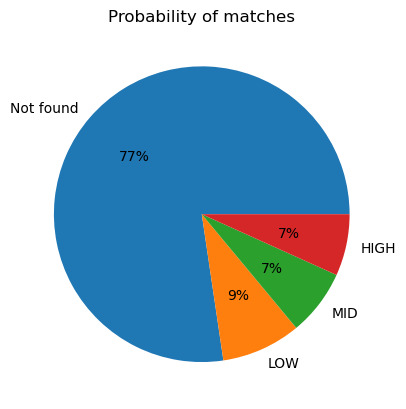

In [300]:
tickers.probability.fillna('Not found').value_counts().plot.pie(autopct="%.0f%%", title = 'Probability of matches', ylabel = '')
plt.show()

In [301]:
#merge the cusips and tickers onto the PRC data
new_data = prc_data.copy()
percentage_of_cusips = {}
percentage_probas = []
for i,col in enumerate(NoE_columns):
    temp = tickers[tickers.PRC_NoE.isin(prc_data[col])].rename(columns = {'ticker':'ticker'+str(i+1),
                                                                          'cusip':'cusip'+str(i+1),
                                                                          'probability':'probability'+str(i+1)})
    new_data = pd.merge(new_data, temp, left_on = col, right_on = 'PRC_NoE', how = 'left').drop(columns = 'PRC_NoE')
    
    nb_cusips = (~new_data['cusip'+str(i+1)].isnull()).sum()
    nb_observations_total = (~new_data[col].isnull()).sum()
    percentage_of_cusips['cusip'+str(i+1)] = nb_cusips/nb_observations_total
    
    v_counts = new_data[(~new_data['cusip'+str(i+1)].isnull())]['probability'+str(i+1)].value_counts()
    percentage_probas.append(v_counts/nb_cusips)
total_number = new_data.filter(like = 'cusip').dropna(how = 'all').shape[0]

Total number of events with at least one cusip = 2281, out of 8254 events.


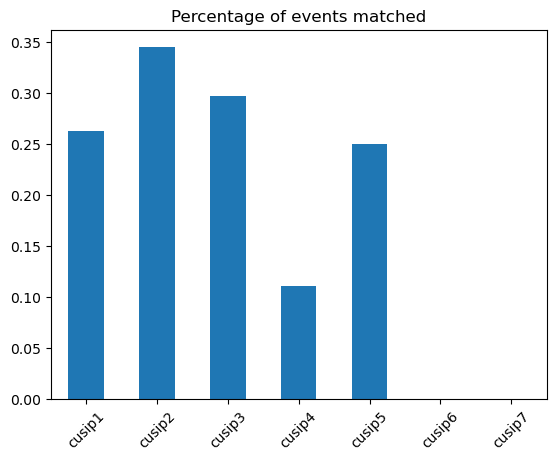

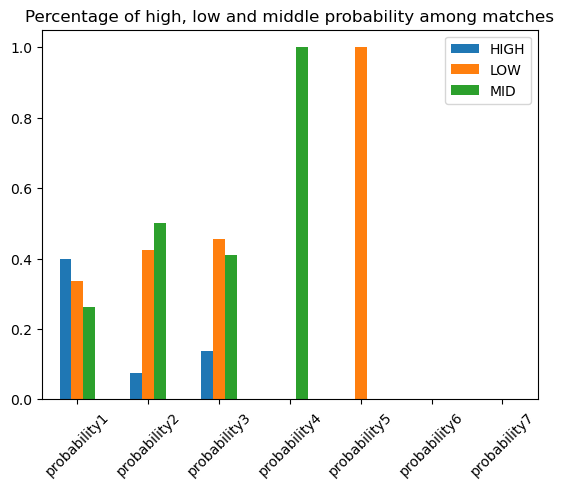

In [303]:
print(f'Total number of events with at least one cusip = {total_number}, out of {new_data.shape[0]} events.')

pd.DataFrame(percentage_of_cusips.items(), columns = ['','percentage']).set_index('').plot.bar(legend = False)
plt.xticks(rotation = 45)
plt.title('Percentage of events matched')
plt.show()

pd.concat(percentage_probas, axis = 1).T.plot.bar()
plt.xticks(rotation = 45) 
plt.title('Percentage of high, low and middle probability among matches')
plt.show()

Number of events with at least one hogh probability cusip : 876


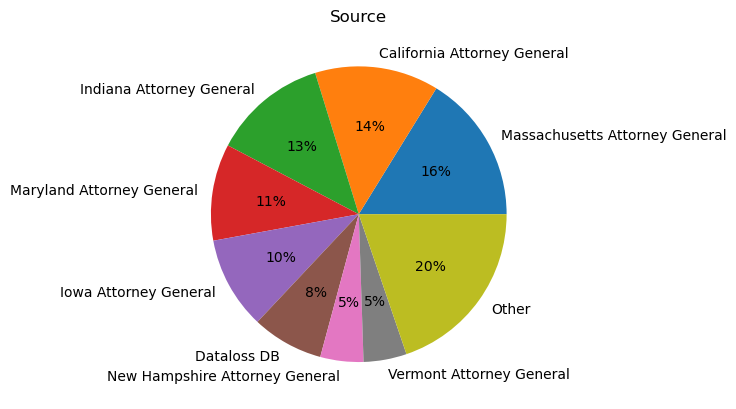

Other category regroups the following:


Databreaches.net                                                                                                3.8
Montana Attorney General                                                                                        3.7
Washington Attorney General                                                                                     2.5
Maine Attorney General                                                                                          2.2
US Department of Health and Human Services                                                                      1.7
Krebs On Security                                                                                               1.1
Oregon Attorney General                                                                                         0.9
Wisconsin Attorney General                                                                                      0.8
Maryland Attorney General, Montana Attorney General, New Hampshire Attor

In [409]:
temp = new_data[new_data.filter(like='probability').apply(lambda col: col.str.contains('HIGH')).any(axis=1)]
print(f'Number of events with at least one hogh probability cusip : {len(temp)}')

# Compute the value counts of organization types
value_counts = temp[~temp['Report Date Available'].isnull()].Source.value_counts()

# Calculate the percentage for each organization type
percentage = (value_counts / value_counts.sum()) * 100

# Threshold for grouping into "Other" category (5%)
threshold = 4

# Create a mask for organization types with percentage less than the threshold
mask = percentage < threshold

# Group organization types with less than threshold into "Other" category
other_count = value_counts[mask].sum()
value_counts = value_counts[~mask]
value_counts['Other'] = other_count

value_counts.plot.pie(autopct="%.0f%%",ylabel = '', title = 'Source')
plt.show()

print('Other category regroups the following:')
percentage[mask].round(1)

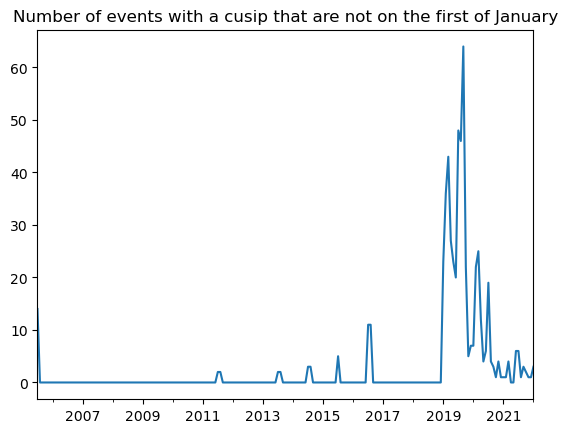

In [458]:
temp = new_data[(new_data['Report Date Available'] == 'Yes') & (~new_data['Reported Date'].str.contains('1/1')) & 
                (new_data.filter(like='probability').apply(lambda col: col.str.contains('HIGH')).any(axis=1))]
temp = pd.to_datetime(temp['Reported Date']).dt.to_period('M')
temp = temp.value_counts()
complete_months = pd.date_range(start=temp.index.to_timestamp().min(), end=temp.index.to_timestamp().max(), freq='M')
temp = temp.reindex(complete_months.strftime('%m/%Y'), fill_value=0)
temp = temp.sort_index(key=lambda x: pd.to_datetime(x, format='%m/%Y'))
temp.index = pd.to_datetime(temp.index)
temp.plot()
plt.title('Number of events with a cusip that are not on the first of January')
plt.show()

In [473]:
test = new_data[(new_data['Report Date Available'] == 'Yes') & (~new_data['Reported Date'].str.contains('1/1')) & 
                (new_data.filter(like='probability').apply(lambda col: col.str.contains('HIGH')).any(axis=1))]
test.loc[26:27].iloc[:,:16]

,Name of Entity,Address Line 1,Address Line 2,Address State,Address Country,Description,Date of Breach,Records Affected,Reported Date,Source,PDF,Type of Breach,Explanation for Type of Breach,Organization Type,Explanation for Type of Organization,Report Date Available
26,Nordstrom Corporation,NaN,NaN,Iowa,United States,"This June, we identified three customers who h...",NOT PROVIDED,14,7/3/2005,Iowa Attorney General,https://www.iowaattorneygeneral.gov/media/cms/...,CARD,The breach involved fraud involving debit and ...,BSR,"The breach description mentions ""online accoun...",Yes
27,Nordstrom Corporation,NaN,NaN,Iowa,United States,"This June, we identified three customers who h...",NOT PROVIDED,14,7/3/2005,Iowa Attorney General,https://www.iowaattorneygeneral.gov/media/cms/...,CARD,14 of the 17 customers who reported fraud had ...,BSR,The company in question is Nordstrom Corporati...,Yes


In [318]:
new_data[new_data.NoE1 == 'atlantis']

,Name of Entity,Address Line 1,Address Line 2,Address State,Address Country,Description,Date of Breach,Records Affected,Reported Date,Source,...,probability4,ticker5,cusip5,probability5,ticker6,cusip6,probability6,ticker7,cusip7,probability7
1369,"Atlantis, Paradise Island",NaN,NaN,GRB,Bahamas,"""Atlantis, Paradise Island (the â‚¬Å“Resortâ‚¬...",1/1/16 & 10/21/16,0 & NOT PROVIDED,1/1/2016,California Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474,"Atlantis, Paradise Island",NaN,NaN,NaN,United States,The Resort began investigating unusual activit...,10/21/2016,NOT PROVIDED,7/24/2016,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1475,"Atlantis, Paradise Island",NaN,NaN,NaN,United States,The Resort began investigating unusual activit...,3/9/2016,NOT PROVIDED,7/24/2016,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1476,"Atlantis, Paradise Island",NaN,NaN,NaN,United States,Through the ongoing third-party forensic inves...,3/9/2016,NOT PROVIDED,7/24/2016,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1531,"Atlantis, Paradise Island",NaN,NaN,NaN,United States,The Resort began investigating unusual activit...,10/21/2016,NOT PROVIDED,8/14/2016,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1532,"Atlantis, Paradise Island",NaN,NaN,NaN,United States,The Resort began investigating unusual activit...,3/9/2016,NOT PROVIDED,8/14/2016,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1533,"Atlantis, Paradise Island",NaN,NaN,NaN,United States,Through the ongoing third-party forensic inves...,3/9/2016,NOT PROVIDED,8/14/2016,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7836,"Atlantis, Paradise Island",NaN,NaN,Iowa,United States,The Resort began investigating unusual activit...,10/21/2016,NOT PROVIDED,???7/8/1905???,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7837,"Atlantis, Paradise Island",NaN,NaN,Iowa,United States,The Resort began investigating unusual activit...,3/9/2016,NOT PROVIDED,???7/8/1905???,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7838,"Atlantis, Paradise Island",NaN,NaN,Iowa,United States,Through the ongoing third-party forensic inves...,3/9/2016,NOT PROVIDED,???7/8/1905???,Iowa Attorney General,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [600]:
stocknames[stocknames.comnam.str.contains('DIDI') ]

,permno,namedt,nameenddt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,permco,hexcd,cusip,st_date,end_date,namedum
19880,21374.0,2021-06-30,2022-06-10,31.0,1.0,7389.0,23292E10,DIDI,DIDI GLOBAL INC,None,58336.0,1.0,23292E10,2021-06-30,2022-06-10,2.0


In [328]:
new_data.to_csv('../data/PRC/PRC_augmented.csv', index = False)

In [ ]:
import abydos.distance as abd
index = prc_data['Name of Entity'].unique()
columns = stocknames.comnam
match = pd.DataFrame(np.ones([len(index),len(columns)])*np.nan,index = index, columns = columns) 
for i in tqdm(range(match.shape[0]), desc = 'Computing comname similarities'):
    for j in range(match.shape[1]):
        match.iloc[i,j] = abd.DiscountedLevenshtein().sim(index[i],columns[j])
match